## Importing Libraries

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
import logging
logging.basicConfig(level=logging.ERROR)
# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [2]:
from transformers import AutoTokenizer, AutoModel

# Load the FINQA tokenizer.
print('Loading FINQA tokenizer...')
tokenizer = AutoTokenizer.from_pretrained('roberta-large-mnli')

Loading FINQA tokenizer...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/688 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [3]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
!ls "/content/drive/MyDrive/TUDelft/NLP Group Project"

Mounted at /content/drive/
 abhi_deberta_bm25.ipynb		       Jasper_DecompClaim.ipynb
 abhi_deberta_customclaimdecomp.ipynb	       Jasper_mDeBERTa_bm25.ipynb
 abhi_programfc_bm25.ipynb		       Jasper_mDeBERTa_customclaimdecomp.ipynb
 Archive				       Jasper_mDeBERTa_oracle.ipynb
 bart_customclaimdecomp.ipynb		       Jasper_mDeBERTa_programfc.ipynb
 bart_customclaimdecomp-outputs		       math_bert-outputs
 bart-mnli-outputs			       mdberta_programfc-outputs
 bart-mnli-outputs-ORACLE		       mdeberta-customclaimdecomp-outputs
 bart_programfc.ipynb			       mDeBERTa_customclaimdecomp-outputs
 bart_programfc-outputs			       mdeberta-outputs
 bm25					       mdeberta-outputs-ORACLE
 bm25_of_programfc			       numt5-outputs
 bm25_of_subclaims			       PASTA_bm25.ipynb
 claim_classifier			       PASTA_customclaimdecomp.ipynb
 claimDecomp				       pasta_model
 custom_claim_decomp			       PASTA_oracle.ipynb
 custom_claimdecomp_dataset.ipynb	       pasta-outputs-bm25
 data					       pasta-o

## Setting up data

In [4]:
import json
with open("/content/drive/MyDrive/TUDelft/NLP Group Project/data/train_claims_quantemp.json") as f:
  train_data = json.load(f)
len(train_data)

9935

In [5]:
train_data[-1]

{'crawled_date': '2014-03-26T10:38:09',
 'country_of_origin': 'ukraine',
 'label': 'False',
 'url': 'https://www.stopfake.org/en/fake-commandos-from-berkut-who-refused-to-kneel-have-been-burned-alive-in-lviv/',
 'lang': 'en',
 'claim': 'FAKE:  Commandos from &#8220;Berkut&#8221; who refused to kneel have been burned alive in Lviv',
 'doc': 'The Russian TV channel “Russia 1” aired a program called “Evil spirits of Maydan: mystic of Ukrainian mayhem”. The program, among other things, referred to the claim that two soldiers of “Berkut”, who refused to kneel in front of Lviv Maydan and recognize the current government, allegedly were burned alive. https://www.youtube.com/watch?v=SUDH0Qbjuao This was reported by the head of the so-called Russian community of Dnepropetrovsk Victor Trukhov. He says, two “Berkut” solders were put on their knees publicly and then burned in Lviv. However, contrary to this claim, a fire occured in Lviv on February 20, 2014 where people from security forces were c

In [6]:
import json
with open("/content/drive/MyDrive/TUDelft/NLP Group Project/data/val_claims_quantemp.json") as f:
  val_data = json.load(f)
len(val_data)

3084

In [7]:
val_data[-1]

{'crawled_date': '2022-10-06T21:00:06',
 'country_of_origin': 'usa',
 'label': 'True',
 'url': 'https://www.politifact.com/factchecks/2021/oct/28/randy-feenstra/biden-administration-predicted-liquid-fuel-cars-ou/',
 'lang': 'en',
 'claim': 'The Biden administration "published a study concluding 4 (of) 5 new cars on the road by 2050 will still require liquid fuels."',
 'doc': 'President Joe Biden was in Michigan’s auto industry hub on Oct. 5 when he said, "the whole world knows that the future of the auto industry is electric." Rep. Randy Feenstra, R-Iowa, had a quick response, writing on Twitter: ".@POTUS no it’s not — in fact, your own administration published a study concluding 4/5 new cars on the road by 2050 will still require liquid fuels ... "It’s past time Biden lives up to his promise to expand clean-burning #biofuels. Don’t mess with the RFS!" Feenstra is correct about the share of cars in the United States projected to use liquid fuels. The U.S. Energy Information Administrat

## Feature processing

In [8]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()

In [9]:
def get_features(data):
  features = []
  evidences = []

  for index, fact in enumerate(data):
    claim = fact["claim"]
    # evidence = fact["doc"]


    feature = "[Claim]:"+claim+"[Evidences]:"+fact["doc"]
    features.append(feature)
  return features




In [10]:
train_features = get_features(train_data)

In [11]:
len(train_features)

9935

In [12]:
train_features[0]

'[Claim]:In her budget speech, Nirmala Sitharaman claimed that the Government distributed 35,000 crore LED bulbs in the country.[Evidences]:Did Finance Minister Nirmala Sitharaman claim the government distributed 35,000 crore LED bulbs under the Ujala scheme? This would imply the Modi govt gave about 300 bulbs to every person in India. At least this is what is being claimed by some social media users who are sharing a screenshot from a news segment on business channel CNBC Awaaz. The photo shows Sitharaman delivering her budget speech while a caption at the bottom reads - "35,000 crore LED bulb baantein gaye" (35,000 crore LED bulbs were distributed). The snapshot gives the impression that Sitharaman said this sentence in her speech. Netizens are displaying shock at this whopping number believing that the finance minister\'s statement is true. Some Congress leaders are also trolling her by sharing the screenshot of the news channel. But, India Today Anti Fake News War Room (AFWA) found

In [13]:
val_features = get_features(val_data)

In [14]:
len(val_features)

3084

In [15]:
val_features[2]

'[Claim]:Says Dino Rossi "stripped" health care "from 45,000 children."[Evidences]:Did Dino Rossi, a Republican Washington state senator running for U.S. Congress, once take away coverage from 45,000 children? That’s what an attack ad by the House Majority PACclaimed. "He’s back. Dino Rossi," the voiceover in the ad says. "Rossi first showed up in Olympia decades ago. He went to work! Health care stripped from 45,000 children." They’re referencing a 2003 budget measure, back when Rossi was the state Senate Ways and Means chairman. The budget was looking bleak, so Republicans proposed large spending cuts that year. One, proposed by Rossi, was a $50 million cut in Medicaid spending. The cut would have eliminated coverage for nearly 40,000 low-income children, according to reporting at the time. But the cut didn’t fly with Democrats, and ended up being scrapped in the final budget. The final budget, which won bipartisan support, wasn\'t a specific cut, but it did include rules changes. Th

In [16]:
train_labels = [fact["label"] for fact in train_data]
val_labels = [fact["label"] for fact in val_data]

In [17]:
# Checking to see what are the possible values of the labels per claim
print(set(train_labels))

{'True', 'False', 'Conflicting'}


In [18]:
train_labels_final = LE.fit_transform(train_labels)
train_labels_final

array([1, 1, 1, ..., 0, 0, 1])

In [19]:
train_labels_final[:20]

array([1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 0, 1, 2, 2, 1, 1, 0])

In [20]:
val_labels_final = LE.transform(val_labels)
val_labels_final

array([1, 1, 2, ..., 1, 0, 2])

In [21]:
val_data[-1]

{'crawled_date': '2022-10-06T21:00:06',
 'country_of_origin': 'usa',
 'label': 'True',
 'url': 'https://www.politifact.com/factchecks/2021/oct/28/randy-feenstra/biden-administration-predicted-liquid-fuel-cars-ou/',
 'lang': 'en',
 'claim': 'The Biden administration "published a study concluding 4 (of) 5 new cars on the road by 2050 will still require liquid fuels."',
 'doc': 'President Joe Biden was in Michigan’s auto industry hub on Oct. 5 when he said, "the whole world knows that the future of the auto industry is electric." Rep. Randy Feenstra, R-Iowa, had a quick response, writing on Twitter: ".@POTUS no it’s not — in fact, your own administration published a study concluding 4/5 new cars on the road by 2050 will still require liquid fuels ... "It’s past time Biden lives up to his promise to expand clean-burning #biofuels. Don’t mess with the RFS!" Feenstra is correct about the share of cars in the United States projected to use liquid fuels. The U.S. Energy Information Administrat

In [22]:
len(val_labels_final)

3084

## Data processing

So now we have :
1. x - claim and its supporting evidence, dont know how it is retrieved.
2. y - labels (true, conflicting, false) in label encoded form

In [23]:
input_ids = []
attention_masks = []

# Looping through each claim evidence pair
for sent in train_features:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
  encoded_dict = tokenizer.encode_plus(
                      sent,                      # Sentence to encode.
                      add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                      max_length = 256,           # Pad & truncate all sentences.
                      pad_to_max_length = True,
                      truncation=True,
                      return_attention_mask = True,   # Construct attn. masks.
                      return_tensors = 'pt',     # Return pytorch tensors.
                  )

  # input_ids — List of token ids to be fed to a model. Based on the vocabulary of the model
  input_ids.append(encoded_dict['input_ids'])

  # And its attention mask (simply differentiates padding from non-padding).
  # attention_mask — List of indices specifying which tokens should be attended to by the model
  # Usually, [PAD] tokens will have 0, whereas all others will have 1
  attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)


# Print sentence 0, now as a list of IDs.
print('Original: ', train_features[0])
print('Token IDs:', input_ids[0])

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  [Claim]:In her budget speech, Nirmala Sitharaman claimed that the Government distributed 35,000 crore LED bulbs in the country.[Evidences]:Did Finance Minister Nirmala Sitharaman claim the government distributed 35,000 crore LED bulbs under the Ujala scheme? This would imply the Modi govt gave about 300 bulbs to every person in India. At least this is what is being claimed by some social media users who are sharing a screenshot from a news segment on business channel CNBC Awaaz. The photo shows Sitharaman delivering her budget speech while a caption at the bottom reads - "35,000 crore LED bulb baantein gaye" (35,000 crore LED bulbs were distributed). The snapshot gives the impression that Sitharaman said this sentence in her speech. Netizens are displaying shock at this whopping number believing that the finance minister's statement is true. Some Congress leaders are also trolling her by sharing the screenshot of the news channel. But, India Today Anti Fake News War Room (AF

In [24]:
val_input_ids = []
val_attention_masks = []

for sent in val_features:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 256,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        truncation=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    val_input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    val_attention_masks.append(encoded_dict['attention_mask'])
# Convert the lists into tensors.
val_input_ids = torch.cat(val_input_ids, dim=0)
val_attention_masks = torch.cat(val_attention_masks, dim=0)


# Print sentence 0, now as a list of IDs.
print('Original: ', val_features[0])
print('Token IDs:', val_attention_masks[0])

Original:  [Claim]:Amit Shah said Narendra Modi sleeps for 24 hours for the welfare of the poor.[Evidences]:The India Today Anti-Fake News War Room found the viral video of Amit Shah's statement was clipped and presented out of context. A short video clip of Union Home Minister Amit Shah has gone viral with the claim that at a political rally, he said that Prime Minister Narendra Modi sleeps 24 hours for the welfare of the poor. Several Twitter and Facebook users shared this video clip with captions like, “Modi ji sleeps for 24 hours”. The India Today Anti-Fake News War Room ( AFWA) found the viral video was clipped and presented out of context to give it a different meaning. In the original video, Shah can be heard saying that PM Modi thinks about the welfare of the poor 24 hours a day while “Didi” (Mamta Banerjee) wonders when her nephew would become the Chief Minister. Shah made the statement while addressing a public meeting in Chapra, West Bengal, in April 2021. The viral posts ar

In [25]:
train_labels_final = torch.tensor(train_labels_final)
val_labels_final = torch.tensor(val_labels_final)

In [26]:
val_labels_final.shape

torch.Size([3084])

In [27]:
len(val_input_ids)

3084

In [28]:
num_classes = len(list(set(train_labels)))
list(set(train_labels))

['True', 'False', 'Conflicting']

In [29]:
num_classes

3

In [30]:
from torch.utils.data import TensorDataset, random_split
# train_poincare_tensor = torch.tensor(poincare_embeddings_final,dtype=torch.float)
# difficulty_tensor = torch.tensor(difficulty_level_vectors,dtype=torch.float)
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, train_labels_final)
val_dataset = TensorDataset(val_input_ids, val_attention_masks,val_labels_final)
#

In [31]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
batch_size = 16
train_dataloader = DataLoader(
            dataset,  # The training samples.
            sampler = RandomSampler(dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )

## Coding the model

In [32]:
from torch import nn
class MultiClassClassifier(nn.Module):
    def __init__(self, model_path, labels_count, hidden_dim=768, mlp_dim=500, extras_dim=100, dropout=0.1, freeze_FINQA=False):
        super().__init__()

        self.FINQA = AutoModel.from_pretrained(model_path, output_hidden_states=True,output_attentions=True)
        self.FINQA.load_state_dict(state_dict_final,strict=False)

        self.dropout = nn.Dropout(dropout)
        self.mlp = nn.Sequential(
#             nn.Linear(hidden_dim, mlp_dim),
            # input is of shape [batch_size, 256, 768]
            nn.Linear(mlp_dim, hidden_dim),
            nn.ReLU(),
            # nn.Linear(mlp_dim, mlp_dim),
            # # nn.ReLU(),
            # # nn.Linear(mlp_dim, mlp_dim),
            # nn.ReLU(),
            nn.Linear(hidden_dim, labels_count)
        )
        '''
        hidden_dim = 1024
        mlp_dim=768
        extras_dim=140
        MLP Input Shape : torch.Size([16, 256, 768])

        nn linear - (in_features, out_features)

        nn linear1 = (1024, 768)
        0.weight torch.Size([768, 1024])
        0.bias torch.Size([768])
        2.weight torch.Size([3, 768])
        2.bias torch.Size([3])
        '''

        # self.softmax = nn.LogSoftmax(dim=1)
        if freeze_FINQA:
            print("Freezing layers")
            for param in self.nlimodel.parameters():
                param.requires_grad = False

    def forward(self, tokens, masks):
#         Input IDs / Tokens : torch.Size([16, 256])
#         Masks : torch.Size([16, 256])

        output = self.FINQA(tokens, attention_mask=masks)
        # output is a dictionary

        # output keys = dict_keys(['last_hidden_state', 'hidden_states', 'attentions'])
        # each hidden state has shape [batch_size, 256, 768]
        # OUTPUT OF ROBERTA IS [batch_size, 1024]
        # each attention mask has shape [batch_size, 12, 256, 256]



        '''
        # Approach that pools the last hidden state
        # [batch_size, 256, 768] -> [batch_size, 768]

        dropout_output = self.dropout(output["last_hidden_state"])
        dropout_output = torch.mean(dropout_output, dim=1)
        '''
        # [CLS] token is usually in the first position
        dropout_output = self.dropout(output["pooler_output"])




        # concat_output = torch.cat((dropout_output, topic_emb), dim=1)
        # concat_output = self.dropout(concat_output)



        mlp_output = self.mlp(dropout_output)
        # proba = self.softmax(mlp_output)

        return mlp_output

In [33]:
state_dict = torch.load("/content/drive/MyDrive/TUDelft/NLP Group Project/FINQA_model/checkpoint_best_0.65.pt", map_location="cpu")

state_dict_final = {}
for key,value in state_dict.items():
  if "plm_model" in key:
    state_dict_final[key.split("plm_model.")[1]] = value

In [34]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Loads BertForSequenceClassification, the pretrained BERT model with a single
num_classes = 3
model = MultiClassClassifier('roberta-large-mnli',num_classes, 768, 1024, 140,dropout=0.1,freeze_FINQA=False)

# model.load_state_dict(torch.load("model_bert_difficulty_prediction/model_weights"))

# Tell pytorch to run this model on the GPU.
model.cuda()


model.safetensors:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

MultiClassClassifier(
  (FINQA): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (

## Setting up training loop

In [35]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [36]:
from transformers import get_linear_schedule_with_warmup


epochs = 20

# Total number of training steps is [number of batches] x [number of epochs].
total_steps = len(train_dataloader) * epochs



In [37]:
len(train_dataloader)

621

In [38]:
1935 * 32

61920

In [39]:
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [40]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [41]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [42]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


In [43]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [44]:
for param in model.FINQA.encoder.layer[0:5].parameters():
    param.requires_grad=False

In [45]:
loss_func = nn.CrossEntropyLoss()

## Training

In [46]:
model.load_state_dict(torch.load(f'/content/drive/MyDrive/TUDelft/NLP Group Project/finqa-outputs-ORACLE/model_weights'))


<All keys matched successfully>

In [47]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()
early_stopping = EarlyStopping(patience=2, verbose=True)
# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_accuracy = 0
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questimport gensim.downloader as api
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        # b_poincare = batch[2].to(device)
        # b_difficulty = batch[3].to(device)
        b_labels = batch[2].to(device)
        # skill_labels = batch[3].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        probas = model(b_input_ids,b_input_mask)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        loss = loss_func(probas, b_labels)
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        # scheduler.step()
        logits = probas.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_train_accuracy += flat_accuracy(logits, label_ids)
    avg_train_accuracy = total_train_accuracy / len(train_dataloader)
    print(" Train Accuracy: {0:.2f}".format(avg_train_accuracy))

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)



    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)

        b_input_mask = batch[1].to(device)
        # b_poincare = batch[2].to(device)
        # b_difficulty = batch[3].to(device)
        b_labels = batch[2].to(device)
        # skill_labels = batch[3].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.

          logits = model(b_input_ids,b_input_mask)

        # Accumulate the validation loss.
        loss = loss_func(logits, b_labels)
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    early_stopping(avg_val_loss, model)
    if early_stopping.early_stop:
      print("Early stopping")
      break
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    output_dir = f'/content/drive/MyDrive/TUDelft/NLP Group Project/finqa-outputs-ORACLE'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    print("Saving model to %s" % output_dir)
    tokenizer.save_pretrained(output_dir)
    torch.save(model.state_dict(), os.path.join(output_dir, 'model_weights'))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 20 ========
Training...


KeyboardInterrupt: 

# Testing

## Run Test set

In [50]:
import torch
import json
from transformers import AutoTokenizer
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report, precision_recall_fscore_support
from collections import defaultdict, Counter

NAME_OF_MODEL = 'finqa'
model = MultiClassClassifier('roberta-large-mnli', labels_count=3, hidden_dim=768, mlp_dim=1024, extras_dim=140, dropout=0.1, freeze_FINQA=False)
model.load_state_dict(torch.load(f'/content/drive/MyDrive/TUDelft/NLP Group Project/{NAME_OF_MODEL}-outputs-ORACLE/model_weights'))

# state_dict = torch.load(f'/content/drive/MyDrive/TUDelft/NLP Group Project/{NAME_OF_MODEL}-outputs-ORACLE/model_weights')

# state_dict_final = {}
# for key,value in state_dict.items():
#   if "plm_model" in key:
#     state_dict_final[key.split("plm_model.")[1]] = value

# model.load_state_dict(state_dict_final,strict=False)

if torch.cuda.is_available():
    model.cuda()
    print("Model moved to GPU.")
else:
    print("GPU not available, using CPU.")

model.eval()
tokenizer = AutoTokenizer.from_pretrained('roberta-large-mnli', do_lower_case=True)

with open('/content/drive/MyDrive/TUDelft/NLP Group Project/data/test_claims_quantemp.json', 'r') as file:
    test_data = json.load(file)
test_labels = [fact["label"] for fact in test_data]
test_features = get_features(test_data)
label_mapping = list(LE.classes_)
print("Label mappings:", label_mapping)

test_labels_final = LE.fit_transform(test_labels)
test_taxonomy_labels = [fact["taxonomy_label"] for fact in test_data]


input_ids = []
attention_masks = []

for sent in test_features:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 256,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        truncation=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
test_labels_final = torch.tensor(test_labels_final)
dataset = TensorDataset(input_ids, attention_masks, test_labels_final)
batch_size = 16
test_dataloader = DataLoader(
            dataset,
            sampler = RandomSampler(dataset), # Select batches randomly
            batch_size = batch_size
        )

loss_func = nn.CrossEntropyLoss()
softmax = nn.Softmax(dim=1)

correct = []
incorrect = []
taxonomy_metrics = defaultdict(lambda: defaultdict(list))
overall_true_labels = []
overall_predictions = []

for i, batch in enumerate(tqdm(test_dataloader, desc="Evaluating")):
    batch = tuple(t.cuda() if torch.cuda.is_available() else t for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        logits = model(b_input_ids, b_input_mask)
        predicted_labels = torch.argmax(softmax(logits), dim=1)
          # Now, predicted labels is one hot encoded.
        start_index = i * batch_size
        for j in range(len(b_labels)):
          decoded_sentence = tokenizer.decode(b_input_ids[j], skip_special_tokens=True)
          true_label = label_mapping[b_labels[j].item()]
          predicted_label = label_mapping[predicted_labels[j].item()]
          taxonomy = test_taxonomy_labels[start_index + j]
          result_info = {
            "Tokenizer_decoded": decoded_sentence,
            "Ground_truth": true_label,
            "Predicted_as": predicted_label,
            "Taxonomy": taxonomy
          }
          if (predicted_labels[j] != b_labels[j]):
            incorrect.append(result_info)
          else:
            correct.append(result_info)
    # Store overall predictions and true labels for overall metrics
    overall_predictions.extend(predicted_labels.cpu().numpy())
    overall_true_labels.extend(b_labels.cpu().numpy())

    # Store predictions for each taxonomy
    start_index = i * batch_size
    for j in range(len(b_labels)):
        taxonomy = test_taxonomy_labels[start_index + j]
        taxonomy_metrics[taxonomy]['true'].append(b_labels[j].item())
        taxonomy_metrics[taxonomy]['pred'].append(predicted_labels[j].item())

# Calculate overall metrics
overall_macro_f1 = f1_score(overall_true_labels, overall_predictions, average='macro', zero_division=0)
overall_weighted_f1 = f1_score(overall_true_labels, overall_predictions, average='weighted', zero_division=0)
_, _, overall_f1_per_class, _ = precision_recall_fscore_support(overall_true_labels, overall_predictions, average=None)

# Prepare to collect taxonomy-specific metrics
taxonomy_specific_metrics = {}
for taxonomy, data in taxonomy_metrics.items():
    macro_f1 = f1_score(data['true'], data['pred'], average='macro')
    weighted_f1 = f1_score(data['true'], data['pred'], average='weighted')
    _, _, f1_per_class, _ = precision_recall_fscore_support(data['true'], data['pred'], average=None)
    taxonomy_specific_metrics[taxonomy] = {
        'macro_f1': macro_f1,
        'weighted_f1': weighted_f1,
        'per_class_f1': f1_per_class
    }

latex_row = "Awesome-Model"
for taxonomy in ["statistical", "temporal", "interval", "comparison"]:
    if taxonomy in taxonomy_specific_metrics:
        latex_row += f" & {taxonomy_specific_metrics[taxonomy]['macro_f1']:.2f} & {taxonomy_specific_metrics[taxonomy]['weighted_f1']:.2f}"
    else:
        latex_row += " & - & -"

# Add per-class F1 scores
latex_row += f" & {overall_f1_per_class[2]:.2f} & {overall_f1_per_class[1]:.2f} & {overall_f1_per_class[0]:.2f}"

# Add overall QUANTemp scores
latex_row += f" & {overall_macro_f1:.2f} & {overall_weighted_f1:.2f} \\\\"

print("\nLatex row:    & M-F1 & W-F1 & M-F1 & W-F1 & M-F1 & W-F1 & M-F1 & W-F1 & T-F1 & F-F1 & C-F1 & M-F1 & W-F1 ")
print(latex_row)



Model moved to GPU.
Label mappings: ['Conflicting', 'False', 'True']


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Evaluating: 100%|██████████| 156/156 [02:01<00:00,  1.29it/s]


Latex row:    & M-F1 & W-F1 & M-F1 & W-F1 & M-F1 & W-F1 & M-F1 & W-F1 & T-F1 & F-F1 & C-F1 & M-F1 & W-F1 
Awesome-Model & 0.59 & 0.67 & 0.58 & 0.66 & 0.55 & 0.65 & 0.57 & 0.64 & 0.54 & 0.82 & 0.39 & 0.58 & 0.66 \\



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Save incorrectly classified for qualitative analysis

In [51]:

correct_dump = json.dumps(correct, indent=4)

with open(f'/content/drive/MyDrive/TUDelft/NLP Group Project/{NAME_OF_MODEL}-outputs-ORACLE/test_results/{NAME_OF_MODEL}_correctly_classified_test_items.json', 'w') as json_file:
    json_file.write(correct_dump)

incorrect_dump = json.dumps(incorrect, indent=4)

with open(f'/content/drive/MyDrive/TUDelft/NLP Group Project/{NAME_OF_MODEL}-outputs-ORACLE/test_results/{NAME_OF_MODEL}_incorrectly_classified_test_items.json', 'w') as json_file:
    json_file.write(incorrect_dump)

## Confusion Matrices

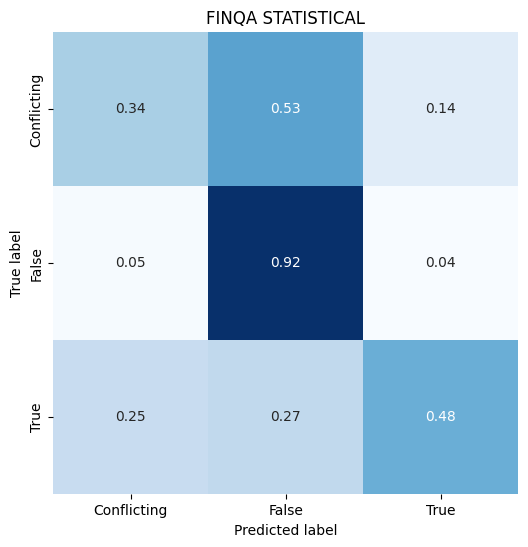

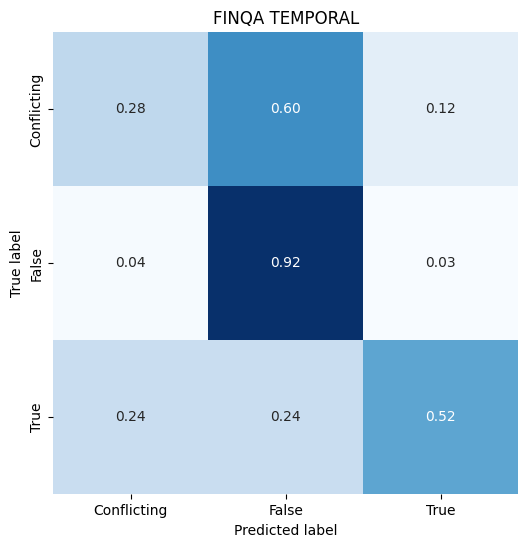

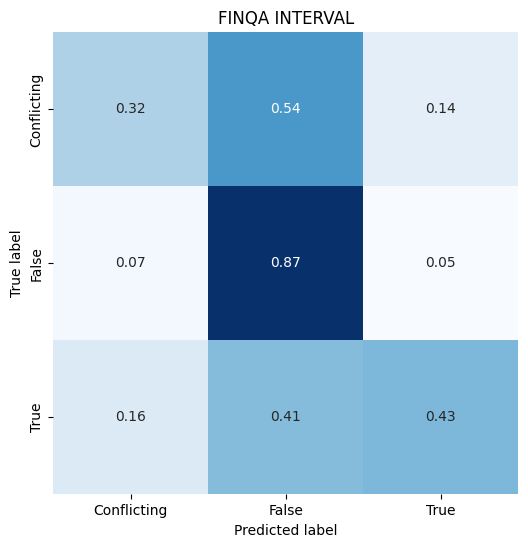

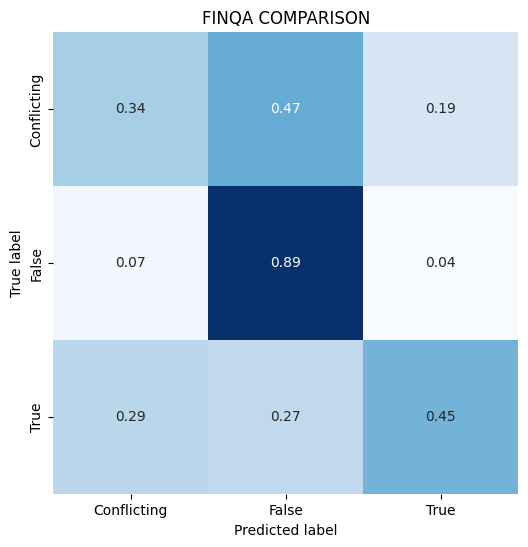

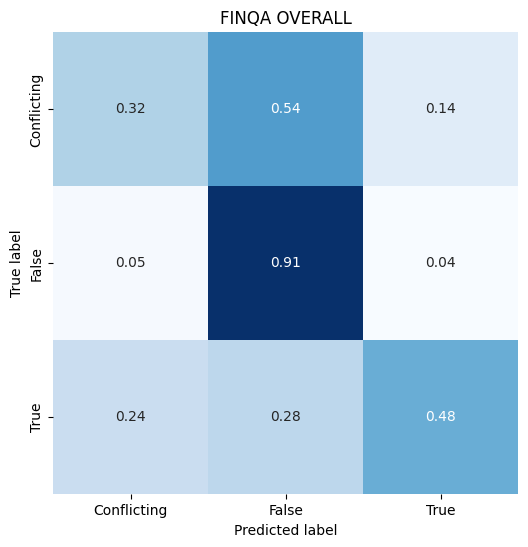

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(cm, class_names, title):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
    title (str): Title of the heatmap.
    """
    # Normalize the confusion matrix.
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(6,6))  # Adjust to fit your needs
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues', cbar=False, ax=ax,
                xticklabels=class_names, yticklabels=class_names)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(title)
    plt.show()
    plt.close()  # Close the plot to avoid direct output
    return fig

# Calculate confusion matrices and plot them
categories = ['statistical', 'temporal', 'interval', 'comparison', 'overall']
class_labels = ['Conflicting', 'False', 'True']

# Generate and save confusion matrix plots
for category in categories:
    true_labels = taxonomy_metrics[category]['true'] if category != 'overall' else overall_true_labels
    pred_labels = taxonomy_metrics[category]['pred'] if category != 'overall' else overall_predictions
    cm = confusion_matrix(true_labels, pred_labels, labels=[0, 1, 2])

    fig = plot_confusion_matrix(cm, class_labels, f'{NAME_OF_MODEL.upper()} {category.upper()}')
    fig.savefig(f'/content/drive/MyDrive/TUDelft/NLP Group Project/{NAME_OF_MODEL}-outputs-ORACLE/confusion_matrices/{NAME_OF_MODEL}_{category}_confusion_matrix.png')  # Save the figure


In [ ]:
from collections import Counter

# Assuming overall_true_labels and overall_predictions are populated
true_label_counts = Counter(overall_true_labels)
predicted_label_counts = Counter(overall_predictions)

# If using LabelEncoder to transform labels, ensure it's fitted as shown previously
label_mapping = list(LE.classes_)  # E.g., ['Conflicting', 'False', 'True']

# Print counts for true labels
print("Counts of each class in the test set:")
for label_index, count in true_label_counts.items():
    print(f"{label_mapping[label_index]}: {count}")

# Print counts for predicted labels
print("\nCounts of each class predicted by the model:")
for label_index, count in predicted_label_counts.items():
    print(f"{label_mapping[label_index]}: {count}")
